In [1]:
import psycopg2
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime


from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import viridis
from alerce.core import Alerce

In [ ]:
client = Alerce()

In [ ]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

In [ ]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [ ]:
mjd_first = Time("2021-03-01T00:00:00", scale='utc').mjd
mjd_last = Time("2021-04-01T00:00:00", scale='utc').mjd

query='''
SELECT
object.oid, object.meanra, object.meandec, object.firstmjd,
object.ndet, probability.probability

FROM object
INNER JOIN probability
ON object.oid=probability.oid

WHERE 
object.firstMJD>%s
AND object.firstMJD<%s
AND object.ndet=1
AND probability.classifier_name='stamp_classifier'
AND probability.class_name='asteroid'
AND probability.probability>0.7
''' % (mjd_first, mjd_last)

ast = pd.read_sql_query(query, conn)
ast.set_index('oid', inplace=True)
print(ast.shape)
ast.head()

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(106895, 5)


,meanra,meandec,firstmjd,ndet,probability
oid,,,,,
ZTF21aanqpwg,156.660014,10.679691,59274.212454,1,0.700072
ZTF21aanqjqc,84.403597,10.469394,59274.147813,1,0.725208
ZTF21aanqpxc,157.088644,15.424231,59274.212454,1,0.728637
ZTF21aanqpzu,156.451785,14.969416,59274.212454,1,0.705238
ZTF21aanqpyv,154.226348,12.072717,59274.212454,1,0.710321


In [ ]:
query='''
SELECT *
FROM ss_ztf
WHERE 
oid in (%s)
AND ssdistnr >= 0
AND ssdistnr <= 5.0
ORDER BY oid
''' % ",".join(["'%s'" % oid for oid in ast.index])

ss = pd.read_sql_query(query, conn)
print(ss.shape)
ss.head()

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(106387, 5)


,oid,candid,ssdistnr,ssmagnr,ssnamenr
0,ZTF18aaavzci,1549155913415015015,0.0,19.9,77314
1,ZTF18aaaxbqb,1549153564115015003,1.0,19.5,36263
2,ZTF18aaaxbuo,1547212622015015006,0.0,18.1,13289
3,ZTF18aabqfyb,1550307190015015012,0.0,19.8,349197
4,ZTF18aabwrag,1549239930415015008,0.0,20.0,175315


In [ ]:
ndet = ss.groupby("ssnamenr").apply(lambda df: df.shape[0])

In [ ]:
ndetmin = 10
X = []
Y = []
Z = []
Q = []
P = []
OID = []
CND = []
for ssnamenr in ndet.loc[ndet>=ndetmin].index:
  query='''
  SELECT *
  FROM ss_ztf
  WHERE 
  ssnamenr = '%s'
  ''' % ssnamenr

  selast = pd.read_sql_query(query, conn)
  selast.set_index("candid", inplace=True)
  query='''
  SELECT candid, mjd, fid, magpsf, sigmapsf, oid
  FROM detection
  WHERE 
  candid in (%s)
  ''' % ",".join(["'%s'" % candid for candid in selast.index])

  selast_lc = pd.read_sql_query(query, conn)
  selast_lc.set_index("candid", inplace=True)
  for fid in selast_lc.fid.unique():
    mask = (selast_lc.fid == fid)

    if len(selast_lc.loc[mask].mjd) > 1 and len(selast_lc.loc[mask].mjd)==len(selast_lc.loc[mask].magpsf) and len(selast_lc.fid.unique())==2: 
      X.append(np.array(selast_lc.loc[mask].mjd).tolist())
      Y.append(np.array(selast_lc.loc[mask].magpsf).tolist())
      Z.append(np.array(selast.loc[selast_lc.index].ssmagnr).tolist())
      P.append(np.array(selast_lc.loc[mask].magpsf - selast.loc[selast_lc.loc[mask].index].ssmagnr).tolist())
      Q.append(np.array(selast_lc.mjd).tolist())
      OID.append(np.array(selast_lc.oid).tolist())
      CND.append(np.array(selast_lc.index).tolist())
      


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\

In [ ]:

Xt = X
Yt = Y
Zt = Z
Qt = Q
Pt = P
Ot = OID
Ct = CND
i=0
while i< len(Xt):

    if len(Xt[i][:150])<150:
        k = len(Xt[i])
        while k < 150:
            Xt[i].append((Xt[i][len(Xt[i])-1]))
            k = k+1    
    else:
        Xt[i]=(Xt[i][:150])
        i=i+1

i=0
while i< len(Yt):
    if len(Yt[i][:150])<150:
        k = len(Yt[i])
        while k < 150:
            Yt[i].append((Yt[i][len(Yt[i])-1]))
            k= k+1
    else:
        Yt[i]=(Yt[i][:150])
    i=i+1

i=0
while i< len(Zt):
    if len(Zt[i][:150])<150:
        k = len(Zt[i])
        while k < 150:
            Zt[i].append((Zt[i][len(Zt[i])-1]))
            k= k+1
    else:
        Zt[i]=(Zt[i][:150])
    i=i+1

i=0
while i< len(Qt):
    if len(Qt[i][:150])<150:
        k = len(Qt[i])
        while k < 150:
            Qt[i].append((Qt[i][len(Qt[i])-1]))
            k= k+1
    else:
        Qt[i]=(Qt[i][:150])
    i=i+1

i=0
while i< len(Pt):
    if len(Pt[i][:150])<150:
        k = len(Pt[i])
        while k < 150:
            Pt[i].append((Pt[i][len(Pt[i])-1]))
            k= k+1
    else:
        Pt[i]=(Pt[i][:150])
    i=i+1

i=0
while i< len(Ot):
    if len(Ot[i][:150])<150:
        k = len(Ot[i])
        while k < 150:
            Ot[i].append((Ot[i][len(Ot[i])-1]))
            k= k+1
    else:
        Ot[i]=(Ot[i][:150])
    i=i+1

i=0
while i< len(Ct):
    if len(Ct[i][:150])<150:
        k = len(Ct[i])
        while k < 150:
            Ct[i].append((Ct[i][len(Ct[i])-1]))
            k= k+1
    else:
        Ct[i]=(Ct[i][:150])
    i=i+1


In [ ]:
j=0
Xt2 = Xt
Yt2 = Yt
Zt2 = Zt
Qt2 = Qt 
Pt2 = Pt
Ot2 =Ot
Ct2 =Ct
while j < len(X):
    Xt2[j]=np.array(Xt[j])
    Yt2[j]=np.array(Yt[j])
    Zt2[j]=np.array(Zt[j])
    Qt2[j]=np.array(Qt[j])
    Pt2[j]=np.array(Pt[j])
    Ot2[j]=np.array(Ot[j]) 
    Ct2[j]=np.array(Ct[j]) 
    j=j+1
Xt2 = np.array(Xt2)
Yt2 = np.array(Yt2)
Zt2 = np.array(Zt2)
Qt2 = np.array(Qt2)
Pt2 = np.array(Pt2)
Ot2 = np.array(Ot2)
Ct2 = np.array(Ct2)

In [ ]:
j=0
Xt3 = []
Yt3 = []
Zt3 = []
Qt3 = [] 
Pt3 = []
Ot3 = []
Ct3 = []
while j < len(Yt)/2:
    Xt3.append(np.concatenate((Xt2[2*j], Xt2[2*j + 1] )))
    Yt3.append(np.concatenate((Yt2[2*j], Yt2[2*j + 1] )))
    Zt3.append( np.concatenate((Zt2[2*j], Zt2[2*j + 1])))
    Qt3.append(np.concatenate((Qt2[2*j], Qt2[2*j + 1] )))
    Pt3.append(np.concatenate((Pt2[2*j], Pt2[2*j + 1] )))
    Ot3.append(np.concatenate((Ot2[2*j], Ot2[2*j + 1] )))
    Ct3.append(np.concatenate((Ct2[2*j], Ct2[2*j + 1] )))
    
    j=j+1
Xt3 = np.array(Xt3)
Yt3 = np.array(Yt3)
Zt3 = np.array(Zt3)
Qt3 = np.array(Qt3)
Pt3 = np.array(Pt3)
Ot3 = np.array(Ot3)
Ct3 = np.array(Ct3)

In [ ]:
j=0
M = []
M2 = []
M3 = []
M3L = Ot3
M3L2 = Ct3
M4 = []
while j < len(Yt3):
    M.append(np.concatenate((Xt3[j], Yt3[j])))
    M2.append(np.concatenate((np.concatenate((Xt3[j], Yt3[j])),np.concatenate((Zt3[j], Qt3[j])))))
    M3.append(np.concatenate((Xt3[j], Pt3[j])))
    j=j+1
M = np.array(M)
M2 = np.array(M2)
M3 = np.array(M3)

In [ ]:
df3 = pd.DataFrame(M3)

Text(0.5, 1.0, 'UMAP projection of Asteroid Data')

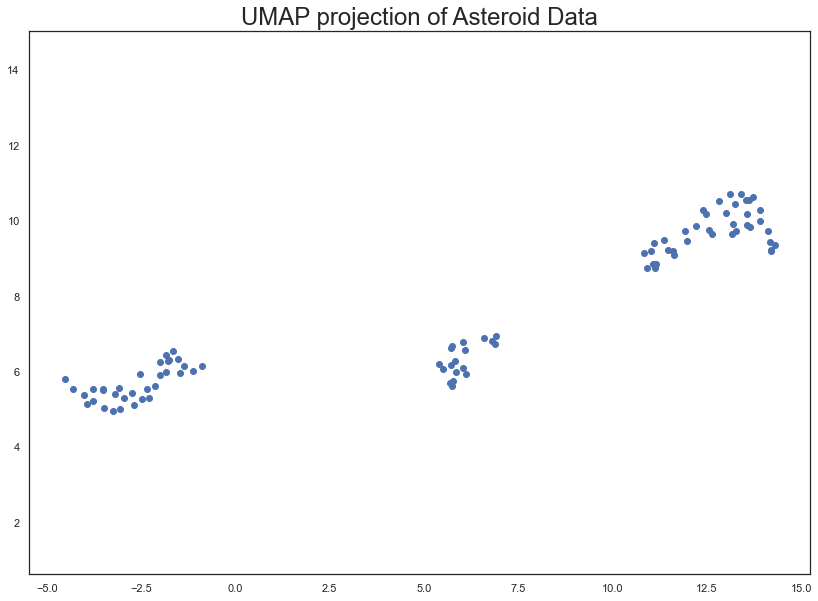

In [ ]:
import umap 
from sklearn.preprocessing import StandardScaler
reducer3 = umap.UMAP(random_state= 2)
scaled_ff3 = StandardScaler().fit_transform(df3)
embedding3 = reducer3.fit_transform(scaled_ff3)
plt.scatter(embedding3[:, 0],embedding3[:, 1]) 
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of Asteroid Data', fontsize=24)

In [ ]:
XfM3 = df3
YfM3 = df3.index.tolist()

In [ ]:
from sklearn.cluster import KMeans
model3 = KMeans(n_clusters=3)
model3.fit(embedding3)
centers3 = model3.cluster_centers_
labels3 = model3.labels_

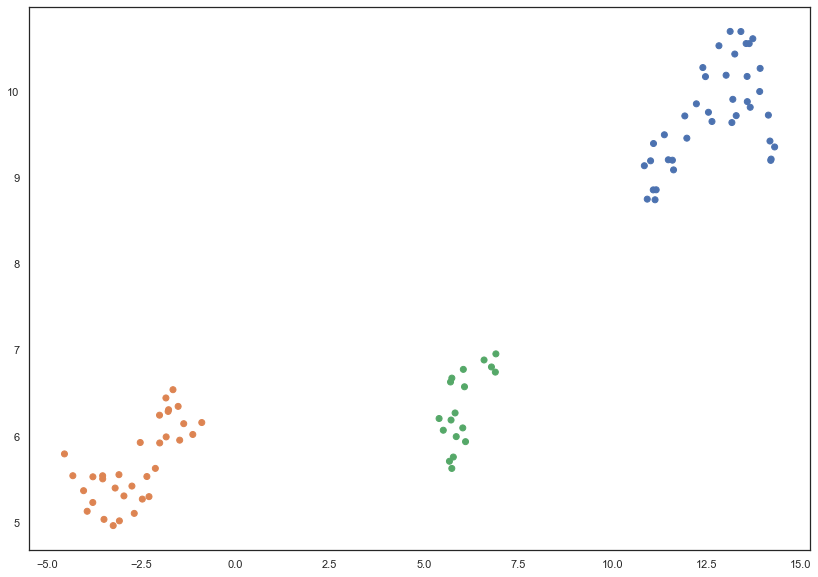

In [ ]:

import seaborn as sns

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
plt.scatter(
    embedding3[:, 0],
    embedding3[:, 1],
    c=[sns.color_palette()[x] for x in labels3])

In [ ]:
XM3f0 = []
XM3f1 = []
XM3f2 = []

XffM3 = np.array(XfM3).tolist()

i=0
while i < len(labels3):
    if labels3[i] == 0:
        XM3f0.append(XffM3[i])
    elif labels3[i] == 1:
        XM3f1.append(XffM3[i])
    elif labels3[i] == 2:
        XM3f2.append(XffM3[i])
    i=i+1

In [ ]:
OIDs0 = []
OIDs1 = []
OIDs2 = []
OIDSM3 = np.array(XfM3).tolist()
i=0
while i < len(labels3):
    if labels3[i] == 0:
        j=0
        while j < len(Ot3[i]):
            OIDs0.append(Ot3[i][j])
            j=j+1
    elif labels3[i] == 1:
        j=0
        while j < len(Ot3[i]):
            OIDs1.append(Ot3[i][j])
            j=j+1
    elif labels3[i] == 2:
        j=0
        while j < len(Ot3[i]):
            OIDs2.append(Ot3[i][j])
            j=j+1
    i=i+1

In [ ]:
Cans0 = []
Cans1 = []
Cans2 = []
CansM3 = np.array(XfM3).tolist()
i=0
while i < len(labels3):
    if labels3[i] == 0:
        j=0
        while j < len(Ct3[i]):
            Cans0.append(Ct3[i][j])
            j=j+1
    elif labels3[i] == 1:
        j=0
        while j < len(Ct3[i]):
            Cans1.append(Ct3[i][j])
            j=j+1
    elif labels3[i] == 2:
        j=0
        while j < len(Ct3[i]):
            Cans2.append(Ct3[i][j])
            j=j+1
    i=i+1

In [ ]:
XprMM = []
XpgMM = []
YprMM = []
YpgMM = []
i=0
while i < len(XM3f0):
    XprMM.append([])
    XpgMM.append([])
    YprMM.append([])
    YpgMM.append([])
    j=0
    while j < len(XM3f0[i]):
        if j < 150:
            XprMM[i].append(XM3f0[i][j])
        elif j < 300:
            XpgMM[i].append(XM3f0[i][j])
        elif j < 450:
            YprMM[i].append(XM3f0[i][j])
        elif j < 600:
            YpgMM[i].append(XM3f0[i][j])
        j=j+1
    i=i+1

In [ ]:
i=0
plt.subplots(figsize=(25, 25))
while i < len(XM3f0):
    plt.subplot(15, 3, i+1)
    plt.plot(XprMM[i],YprMM[i], color = 'r')
    plt.plot(XpgMM[i],YpgMM[i], color = 'g')
    plt.title("First Category M3") 
    # VERDES
    i=i+1
plt.tight_layout()

In [ ]:
XMMpr1 = []
XMMpg1 = []
YMMpr1 = []
YMMpg1 = []
i=0
while i < len(XM3f1):
    XMMpr1.append([])
    XMMpg1.append([])
    YMMpr1.append([])
    YMMpg1.append([])
    j=0
    while j < len(XM3f1[i]):
        if j < 150:
            XMMpr1[i].append(XM3f1[i][j])
        elif j < 300:
            XMMpg1[i].append(XM3f1[i][j])
        elif j < 450:
            YMMpr1[i].append(XM3f1[i][j])
        elif j < 600:
            YMMpg1[i].append(XM3f1[i][j])
        j=j+1
    i=i+1

In [ ]:
i=0
plt.subplots(figsize=(25, 25))
while i < len(XM3f1):
    plt.subplot(15, 3, i+1)
    plt.plot(XMMpr1[i],YMMpr1[i], color = 'r')
    plt.plot(XMMpg1[i],YMMpg1[i], color = 'g')
    plt.title("Second Category M3")
    # Rojos?
    i=i+1
plt.tight_layout()

In [ ]:
XMMpr2 = []
XMMpg2 = []
YMMpr2 = []
YMMpg2 = []
i=0
while i < len(XM3f2):
    XMMpr2.append([])
    XMMpg2.append([])
    YMMpr2.append([])
    YMMpg2.append([])
    j=0
    while j < len(XM3f2[i]):
        if j < 150:
            XMMpr2[i].append(XM3f2[i][j])
        elif j < 300:
            XMMpg2[i].append(XM3f2[i][j])
        elif j < 450:
            YMMpr2[i].append(XM3f2[i][j])
        elif j < 600:
            YMMpg2[i].append(XM3f2[i][j])
        j=j+1
    i=i+1

In [ ]:
i=0
plt.subplots(figsize=(25, 25))
while i < len(XM3f2):
    plt.subplot(15, 3, i+1)
    plt.plot(XMMpr2[i],YMMpr2[i], color = 'r')
    plt.plot(XMMpg2[i],YMMpg2[i], color = 'g')
    plt.title("Third Category M3")
    # Verdes x2?
    i=i+1
plt.tight_layout()